## Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
from scipy import sparse
from anndata import AnnData
import warnings
import socket
from matplotlib import pylab
import sys
import yaml
import seaborn as sns

import os
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
import ipynbname
try:
    nb_fname = ipynbname.name()
except:
    nb_fname = "".join(os.path.basename(globals()["__vsc_ipynb_file__"]).split(".")[:-1])

In [3]:
%matplotlib inline

In [4]:
sc.settings.verbosity = 3         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=50, facecolor='white', dpi_save=500)
pylab.rcParams['figure.figsize'] = (9, 9)


scanpy==1.8.1 anndata==0.7.6 umap==0.4.6 numpy==1.20.2 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


### Configure paths

In [5]:


#indir=paths["paths"]["indir"][hostRoot]
outdir="./outdir"
figDir = "./figures"
#projectBaseDir=paths["paths"]["projectBaseDir"][hostRoot]
markerGenes = "./data/resources/marker_genes.tsv"
markerGenesRefined = "./data/resources/marker_genes_refined.tsv"
colorMapPath = "./colorMap.yaml"

additionalMarkers = ["FGF8","NRG1","NRG3","SFRP2","BMP2","BMP4","WNT3A","WNT5A","WNT2B"]
with open(colorMapPath, 'r') as f:
    colorMap = yaml.load(f, Loader=yaml.FullLoader)["uns_colors"]
colorMap

{'medial': {'color': '#CD5C5C'},
 'distal': {'color': '#FFCBCB'},
 'proximal': {'color': '#8D021F'},
 'piece1': {'color': '#281E5D'},
 'piece2': {'color': '#3779FF'},
 'piece3': {'color': '#BFD4FF'},
 'control': {'color': '#0056D1'},
 'polaroid': {'color': '#DE001E'},
 'enriched': {'color': '#DE001E'},
 'not_enriched': {'color': '#0056D1'},
 'pfc': {'color': '#DE001E'},
 'somatosensory': {'color': '#E5E4E2'},
 'temporal': {'color': '#0056D1'},
 'motor': {'color': '#37F7C8'},
 'v1': {'color': '#28F30C'},
 'parietal': {'color': '#D41FFC'}}

In [6]:
adata = sc.read_h5ad(outdir+"/3_polaroid_quickAnno.h5ad")

In [7]:
markersDF = pd.read_csv(markerGenes, sep="\t")
markersDF.CELLTYPE.unique()

array(['radialglia', 'ExN', 'InN', 'MidBrain', 'Microglia',
       'Oligodendrocytes', 'Astrocytes', 'CBCs/BRG', 'ERstress', 'Retina',
       'mesenchymal', 'CR', 'IPC'], dtype=object)

In [8]:
pd.read_csv(markerGenes, sep="\t").replace("/","_", regex=True).CELLTYPE.unique()

array(['radialglia', 'ExN', 'InN', 'MidBrain', 'Microglia',
       'Oligodendrocytes', 'Astrocytes', 'CBCs_BRG', 'ERstress', 'Retina',
       'mesenchymal', 'CR', 'IPC'], dtype=object)

# UMAP of all markers

In [9]:
markersDF = pd.read_csv(markerGenes, sep="\t").replace("/","_", regex=True)


    

In [10]:
mPlotList =  ["SOX2","NES","VIM","TOP2A","MKI67","RELN","DCX","TUBB3","DLX6-AS1","GAD2","GSX2","RORB","VSX2","GOLGA4",
              "DCN","BGN","COL1A2","TTR","RSPO2","LMX1A","MSX1","PCP4","NPHP1","OLIG1","OLIG2","GFAP","AQP4","AIF1","CD68","NKX2-1"]



In [ ]:
Split=5
for mlist in enumerate([mPlotList[(len(mPlotList)//Split)*i : (len(mPlotList)//Split)*(i+1) ] for i in list(range(Split))]+[mPlotList[-(len(mPlotList)%Split):]]):
    sc.pl.umap(adata, color=mlist[1], size = 30, 
               add_outline = True,outline_width=(0.2, 0.05),vmin="p1",vmax="p99", frameon=False, ncols=7, save="markersChunk_"+str(mlist[0])+"_UMAP.pdf", show=False)

In [11]:
markersDict = markersDF[markersDF.MARKER.isin(adata.var_names)].groupby('CELLTYPE')['MARKER'].apply(list).to_dict()

# Provided marker vs leiden 3

In [12]:
#Load refined dict
markersDictRefined  = pd.read_csv(markerGenesRefined, sep="\t")
markersDictRefined = markersDictRefined[markersDictRefined.MARKER.isin(adata.var_names)].groupby('CELLTYPE')['MARKER'].apply(list).to_dict()


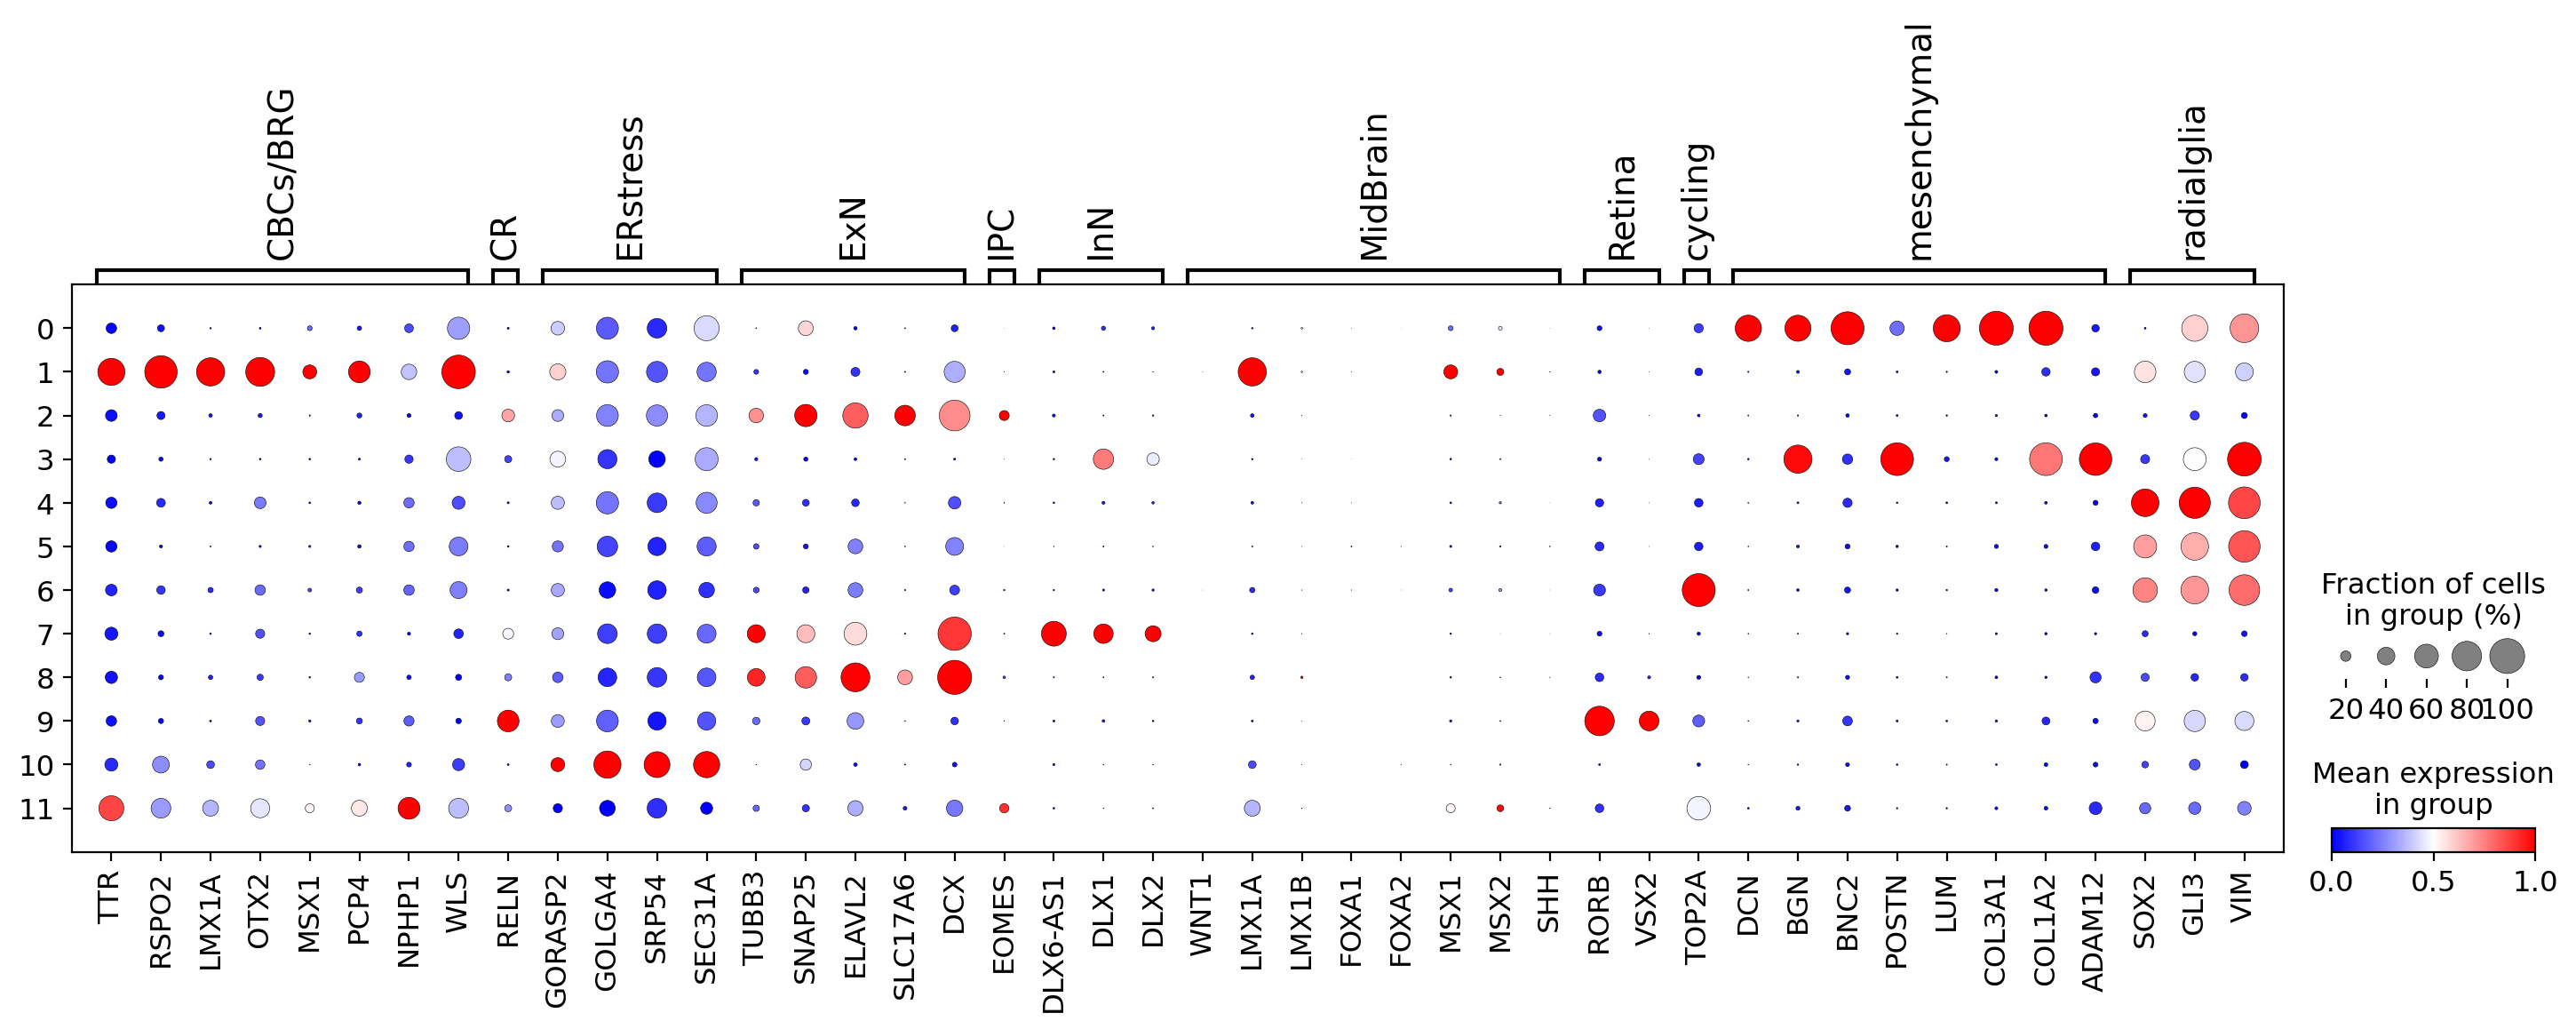

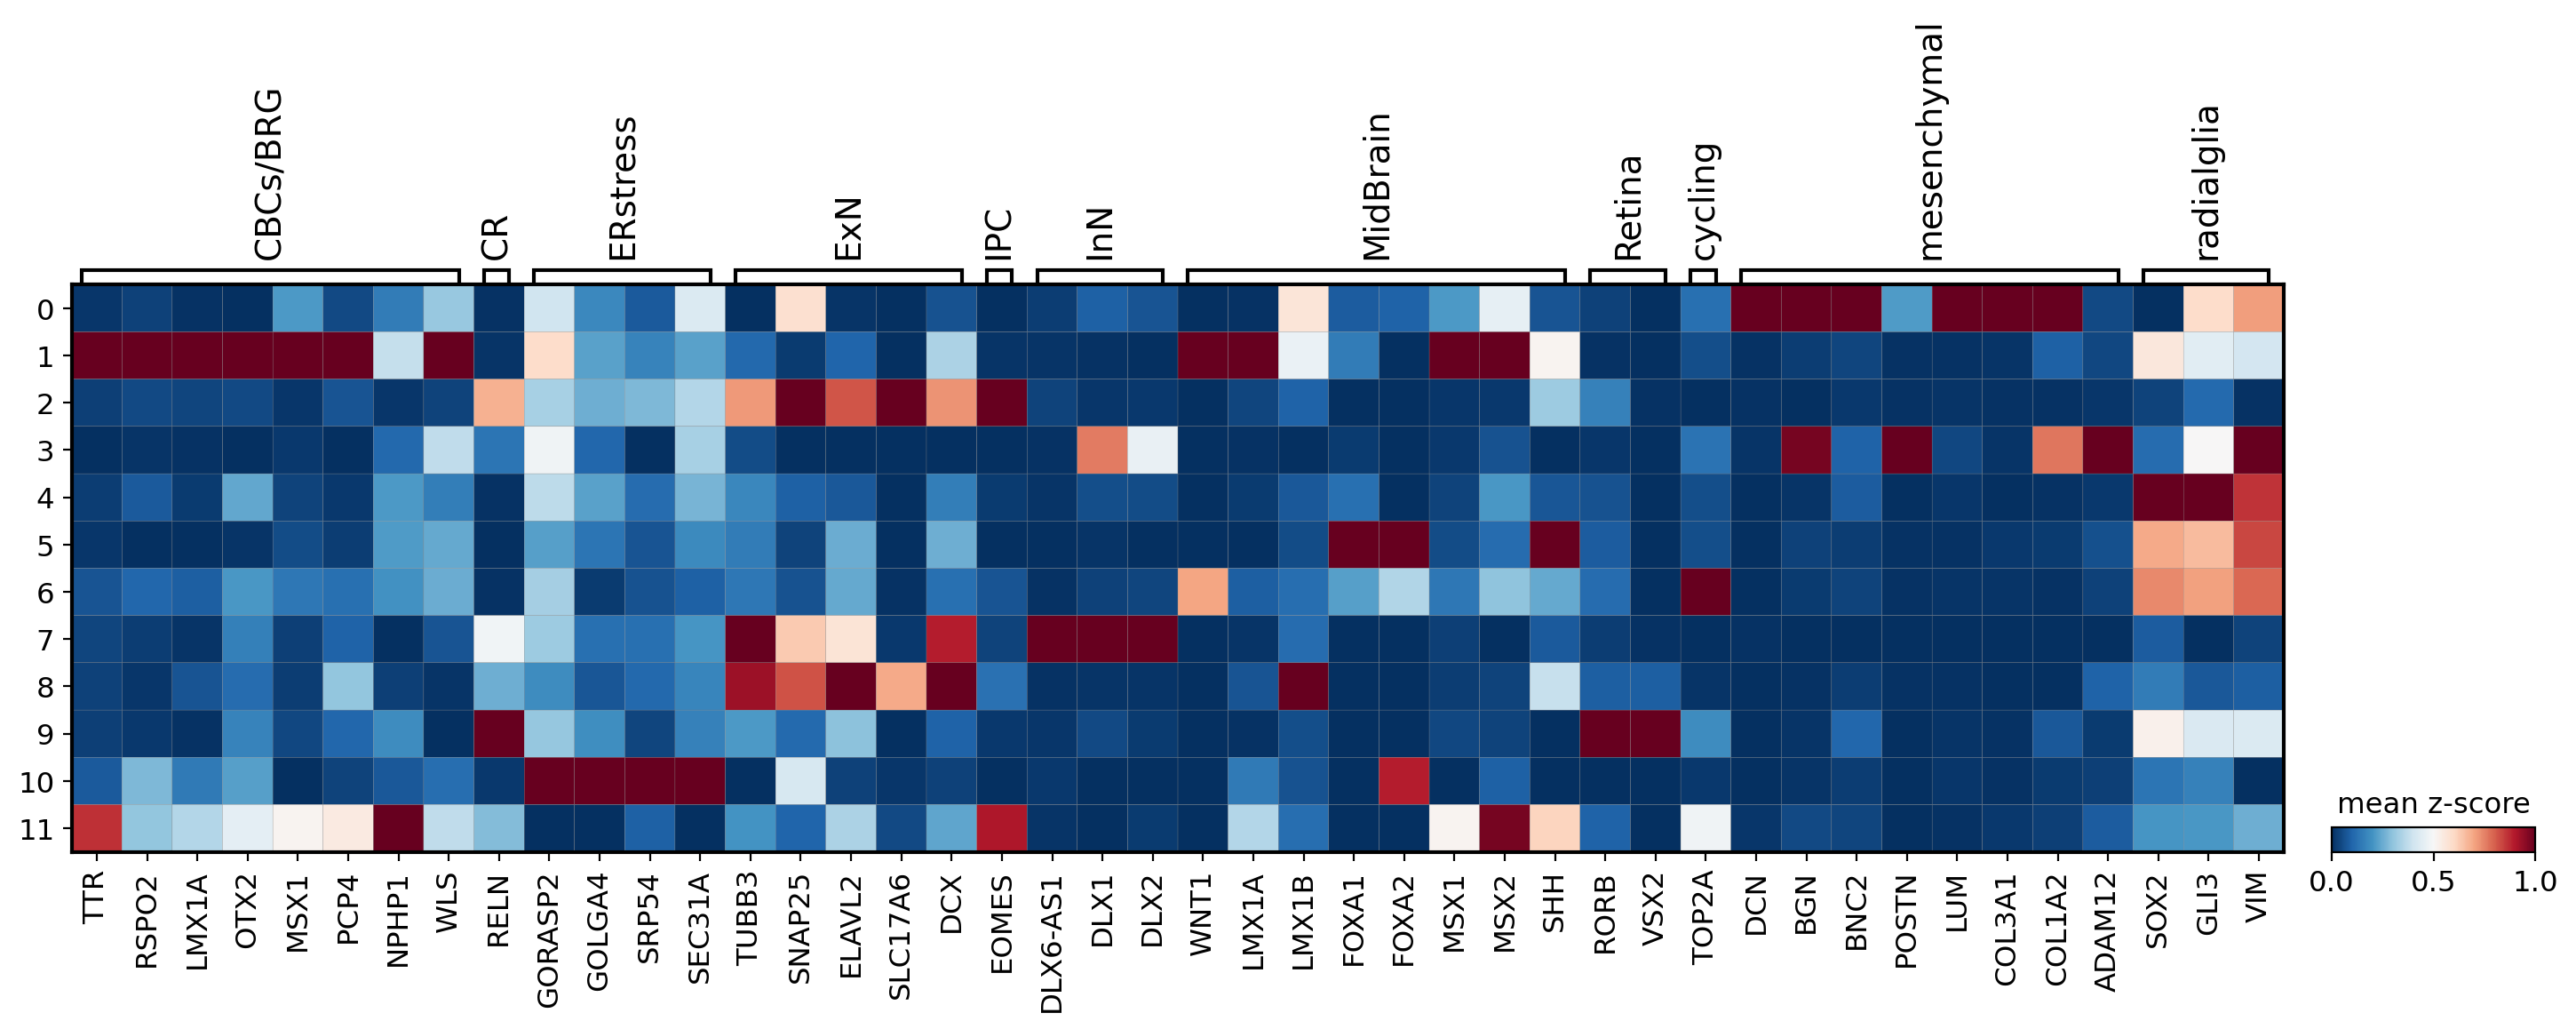

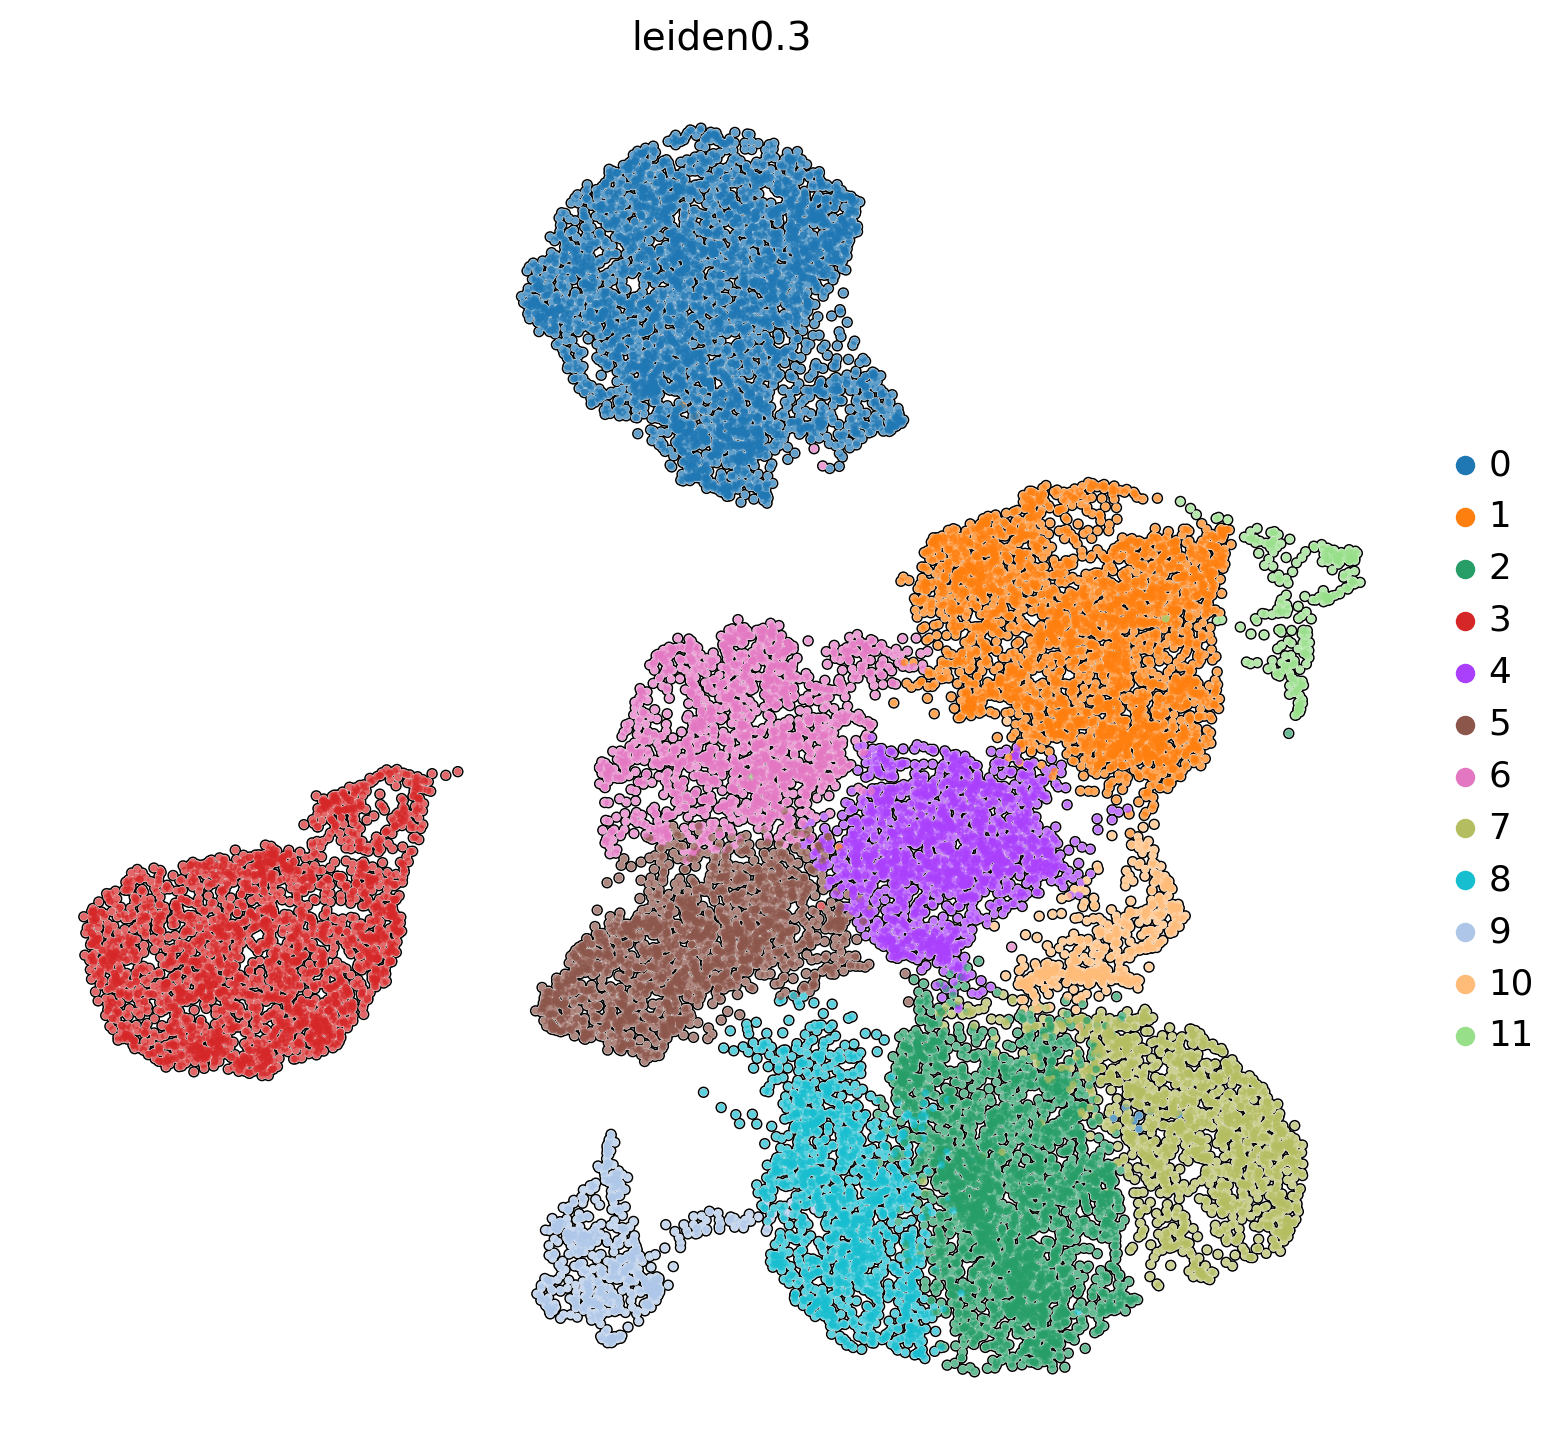

In [13]:
sc.pl.dotplot(adata, markersDictRefined , 
              groupby="leiden0.3",cmap='bwr', use_raw=False,
                     standard_scale ="var")

sc.pl.matrixplot(adata, markersDictRefined, "leiden0.3",swap_axes=False,
                 colorbar_title='mean z-score',cmap='RdBu_r', standard_scale="var")

sc.pl.umap(adata, color="leiden0.3",  size = 30, add_outline = True,outline_width=(0.2, 0.05),vmin="p1",vmax="p99", frameon=False)


# Additional Relevant markers 

## Boxplot

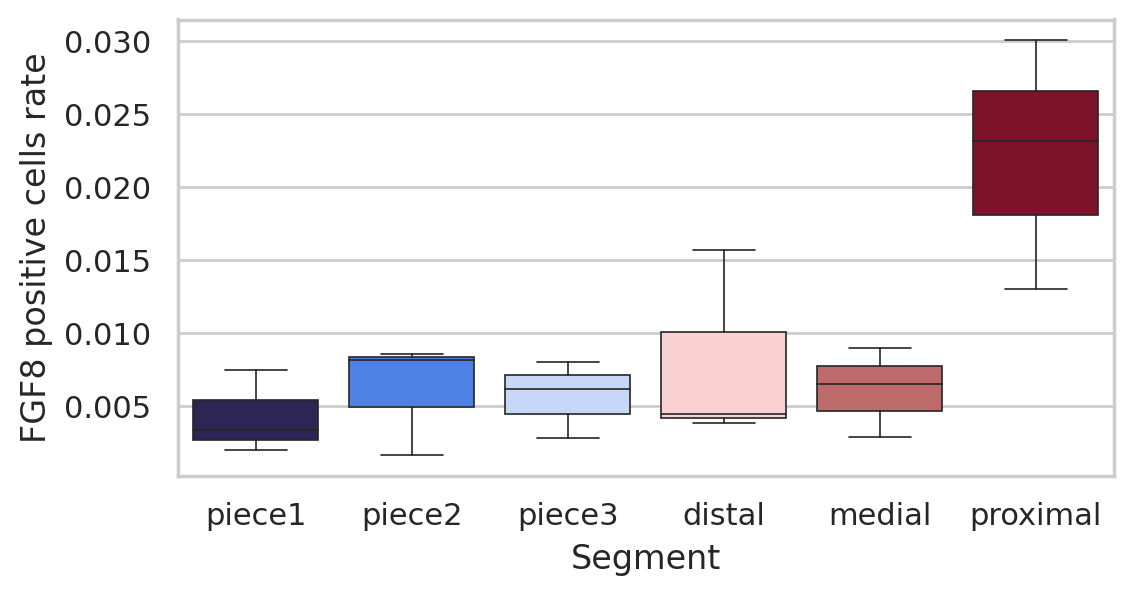

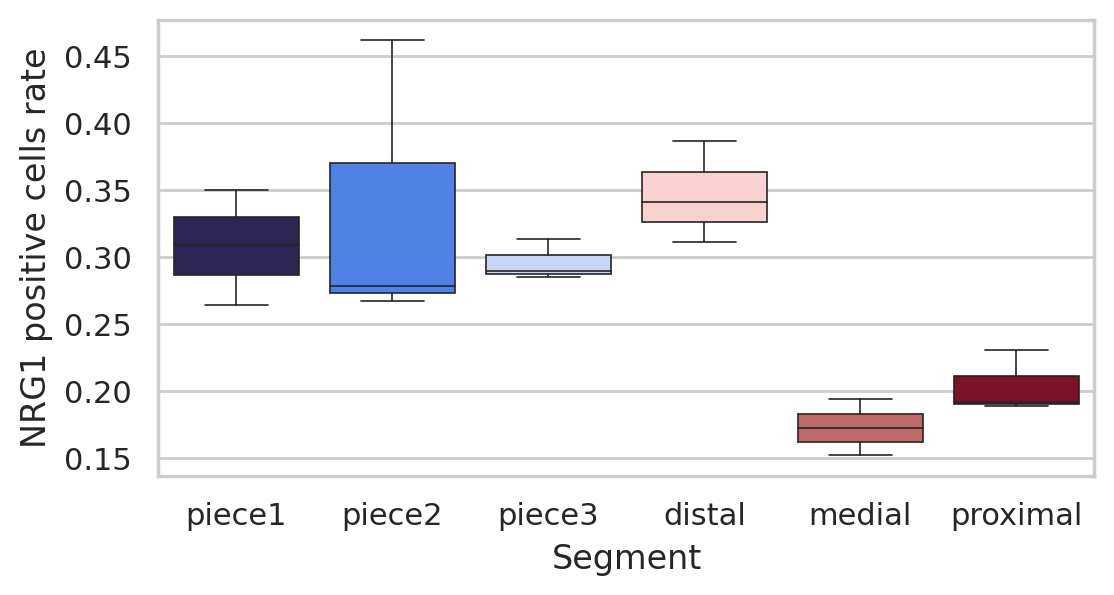

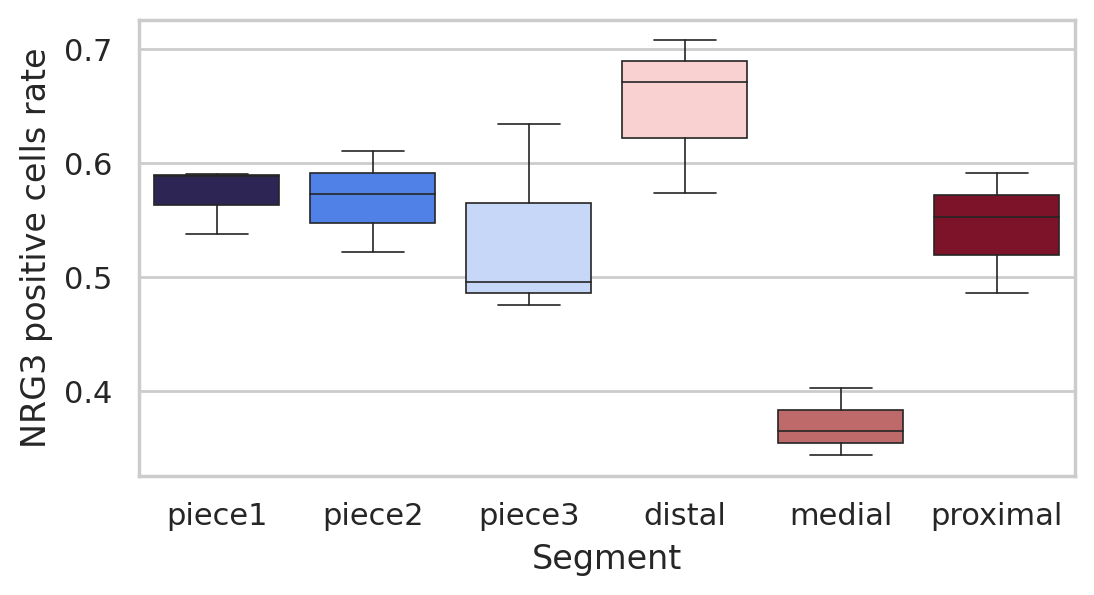

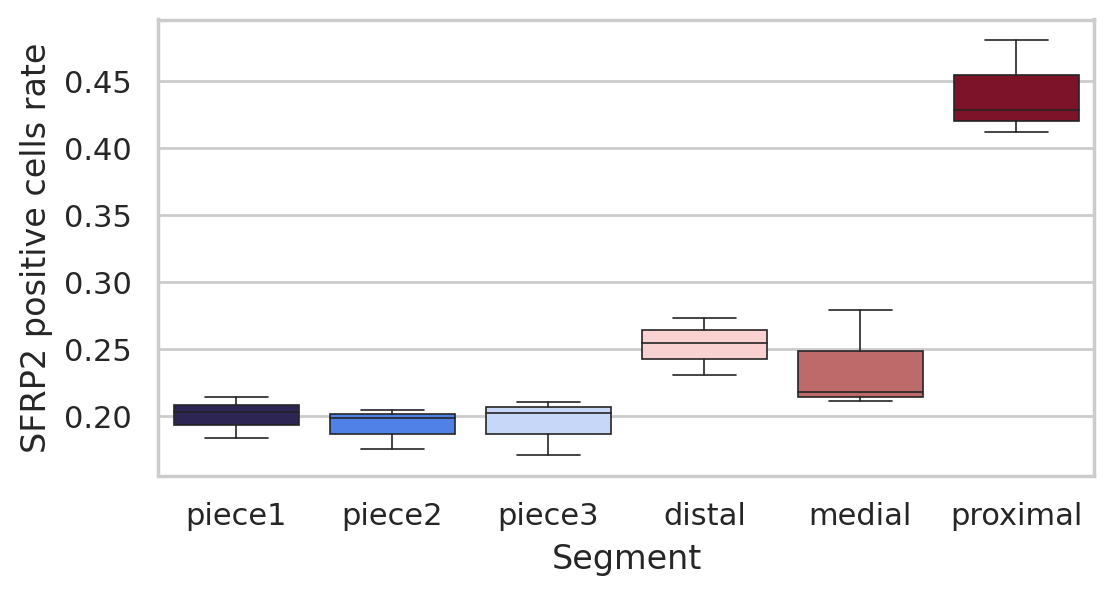

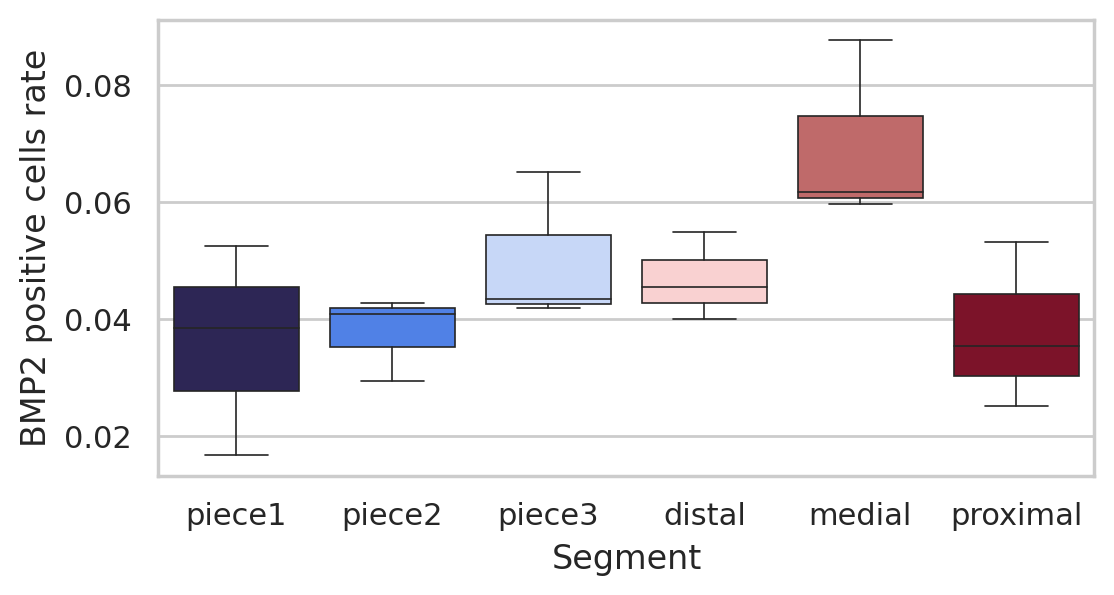

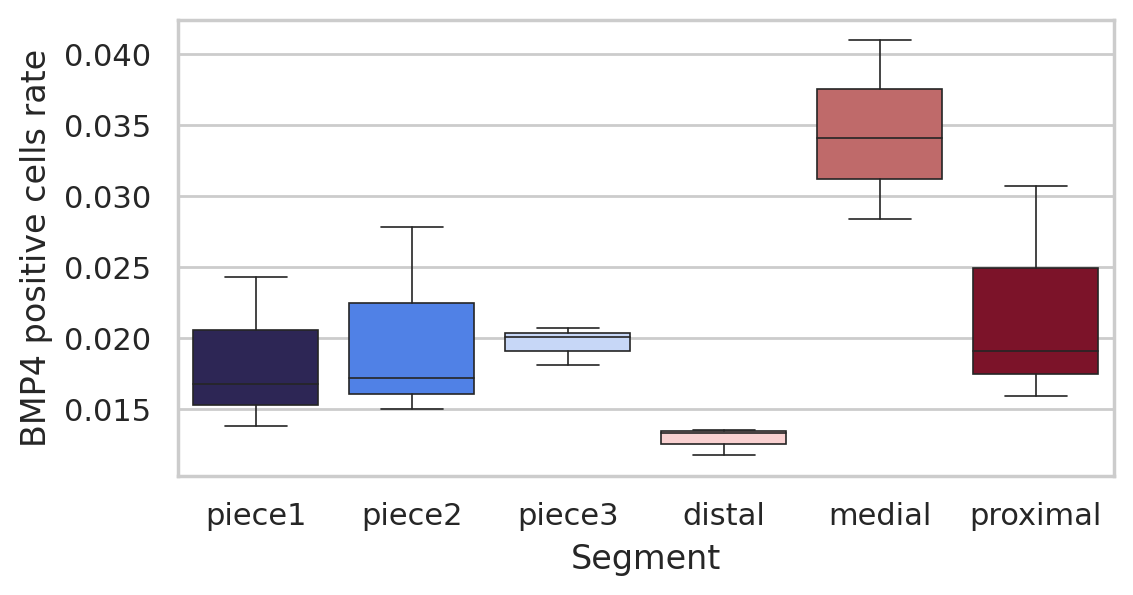

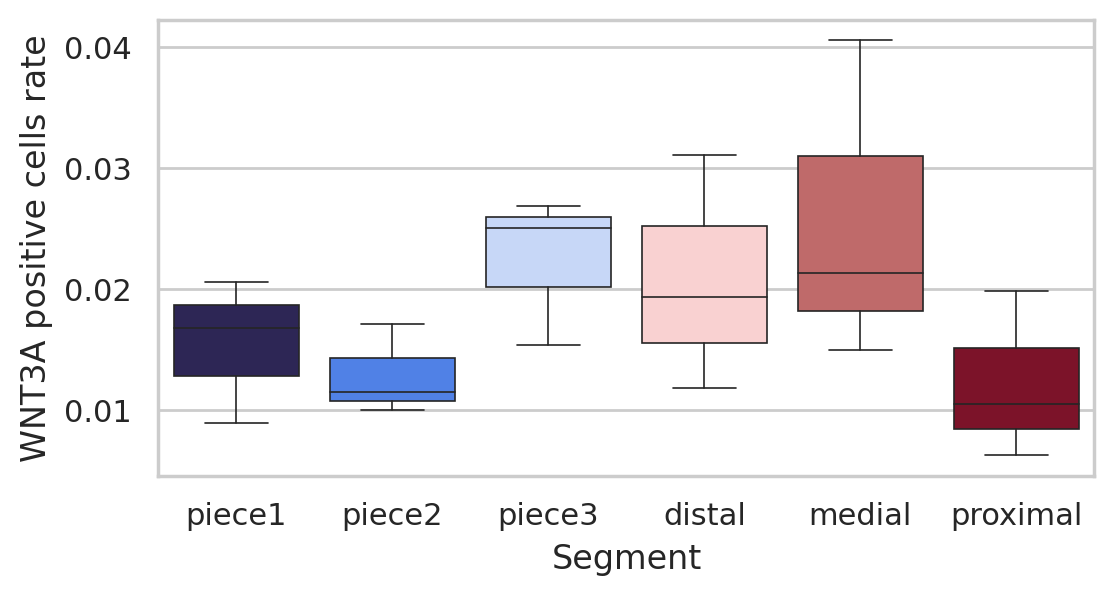

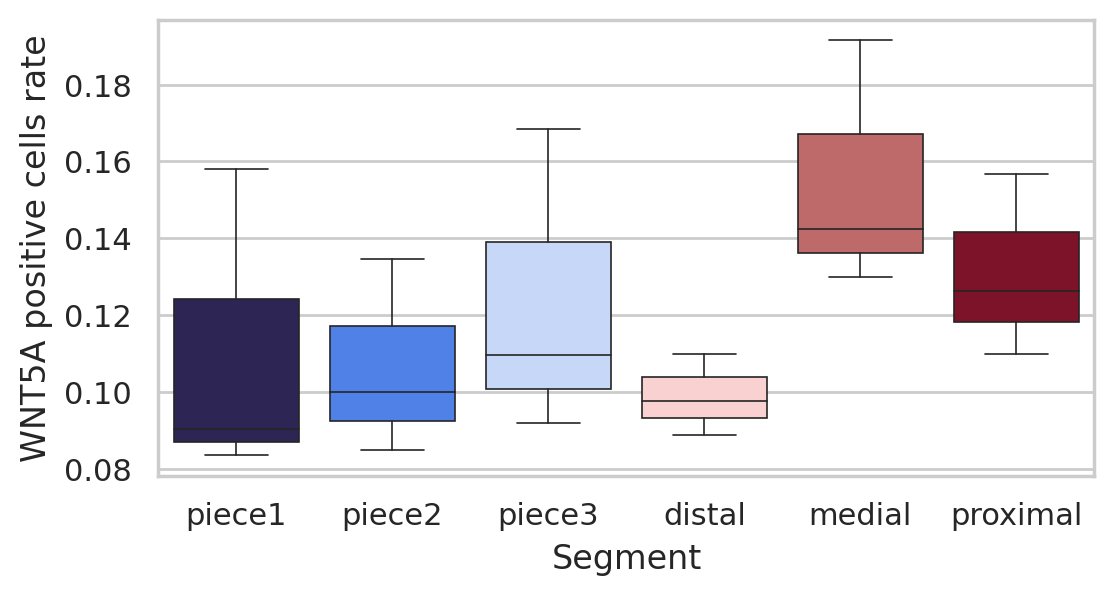

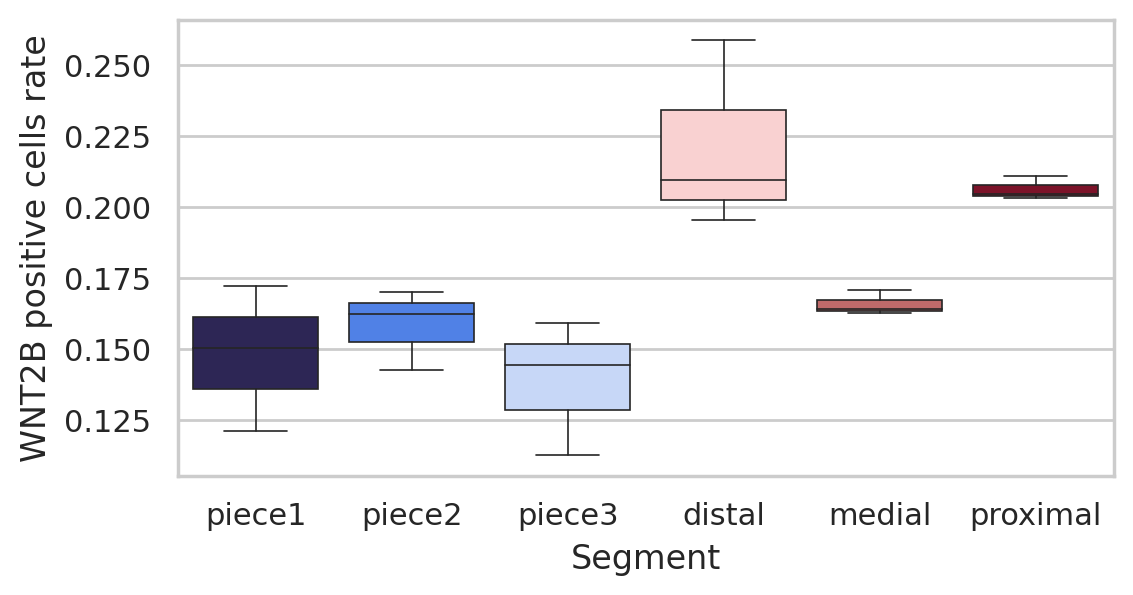

In [14]:
sns.set(rc={'figure.figsize':(6,3)})

sns.set_style("whitegrid")


for gene in  [m for m in additionalMarkers if m in adata.var_names]:
    adataGene = adata.raw.to_adata()[:,gene]
    dummies = pd.get_dummies(adataGene.obs["dataset"])
    
    countsAbove0 = (adataGene.X.todense().A1 > 0).astype(int)
    
    
    SegmentCounts = pd.DataFrame(np.dot(countsAbove0, dummies),columns=[gene+"_positive"])
    SegmentCounts["dataset"] = dummies.columns.tolist()
    SegmentCounts["organoid"] = SegmentCounts["dataset"].str.split("_", expand=True)[0]
    SegmentCounts["Segment"] = SegmentCounts["dataset"].str.split("_", expand=True)[1]

    SegmentCounts["Total_perOrganoid"] = adataGene.obs.groupby(["organoid"]).size().loc[SegmentCounts.organoid].tolist()
    SegmentCounts["Total_perSegment_perOrganoid"] = adataGene.obs.groupby(["dataset"]).size().loc[SegmentCounts.dataset].tolist()
    SegmentCounts[gene+"_positive.NormalizedByOrganoid"] = SegmentCounts[gene+"_positive"] / SegmentCounts["Total_perOrganoid"]
    SegmentCounts[gene+" positive cells rate"] = SegmentCounts[gene+"_positive"] / SegmentCounts["Total_perSegment_perOrganoid"]



    sns.boxplot(data=SegmentCounts, x="Segment", y=gene+" positive cells rate", 
                linewidth=.6,
                palette=dict(zip(SegmentCounts.Segment.unique().tolist(),[colorMap[k]["color"] for k in SegmentCounts.Segment.unique().tolist()])))
    
    plt.savefig(figDir+"/"+nb_fname+"."+gene+".Positive.pdf")
    plt.show()



## MatrixPlot1

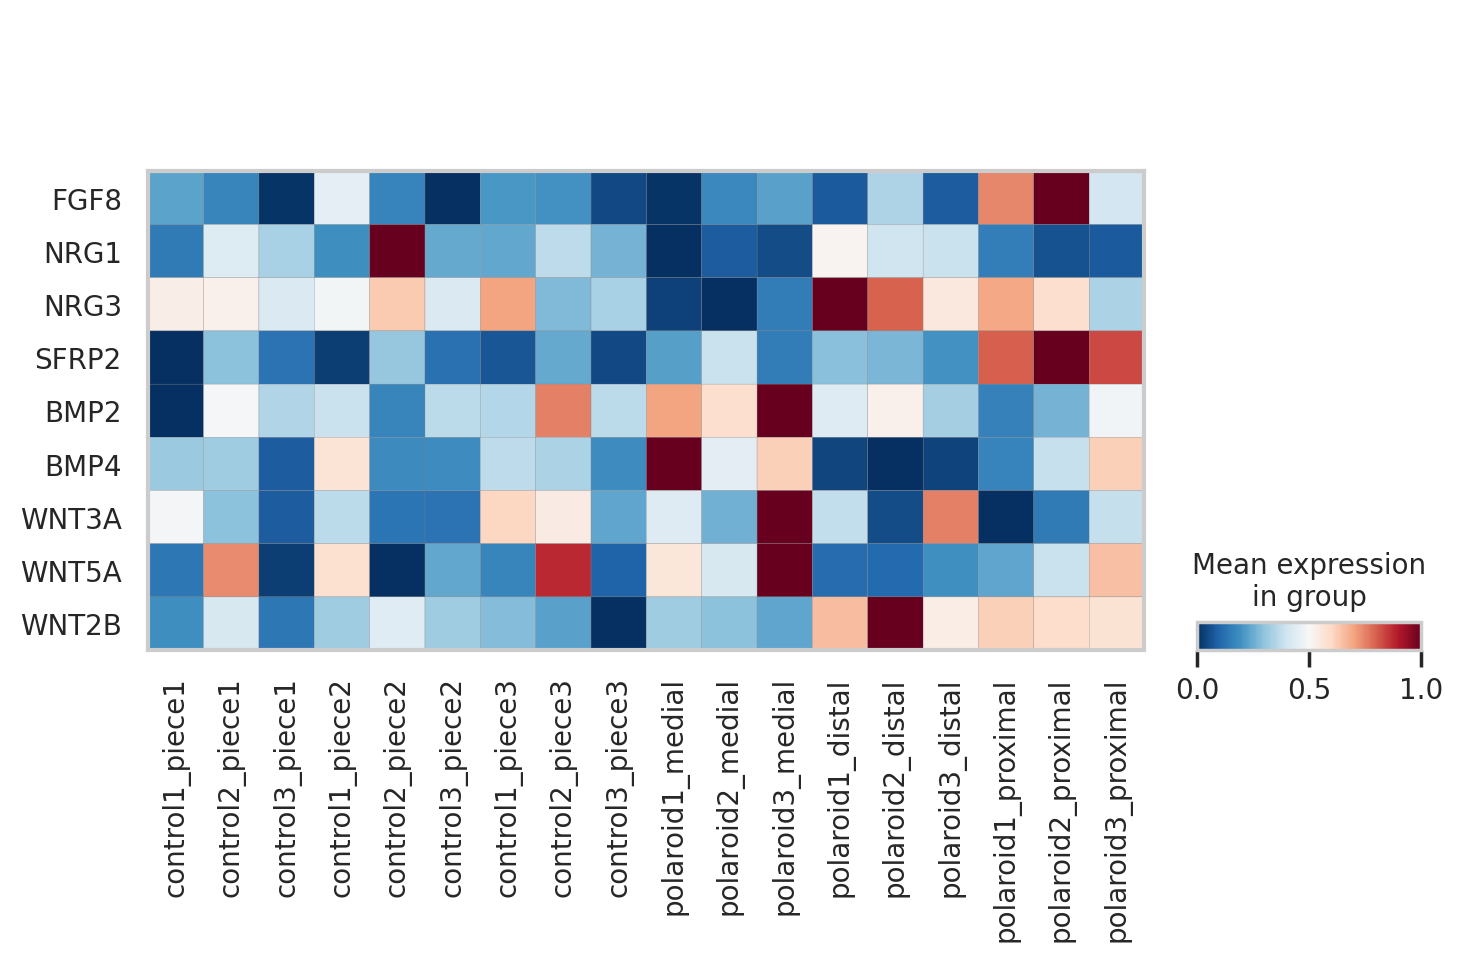

In [15]:
orderCat = ['control1_piece1',
 'control2_piece1',
 'control3_piece1',
 'control1_piece2',
 'control2_piece2',
 'control3_piece2',
 'control1_piece3',
 'control2_piece3',
 'control3_piece3',
 'polaroid1_medial',  
 'polaroid2_medial',     
 'polaroid3_medial',
 'polaroid1_distal',
 'polaroid2_distal',     
 'polaroid3_distal',
 'polaroid1_proximal',
 'polaroid2_proximal',
 'polaroid3_proximal']

sns.set(rc={'figure.figsize':(6,3)})

sns.set_style("whitegrid")


sc.pl.matrixplot(adata, var_names=additionalMarkers,use_raw=True, groupby='dataset', dendrogram=False,
                 categories_order=orderCat,
                cmap='RdBu_r', standard_scale="var",swap_axes=True)

## MatrixPlot2

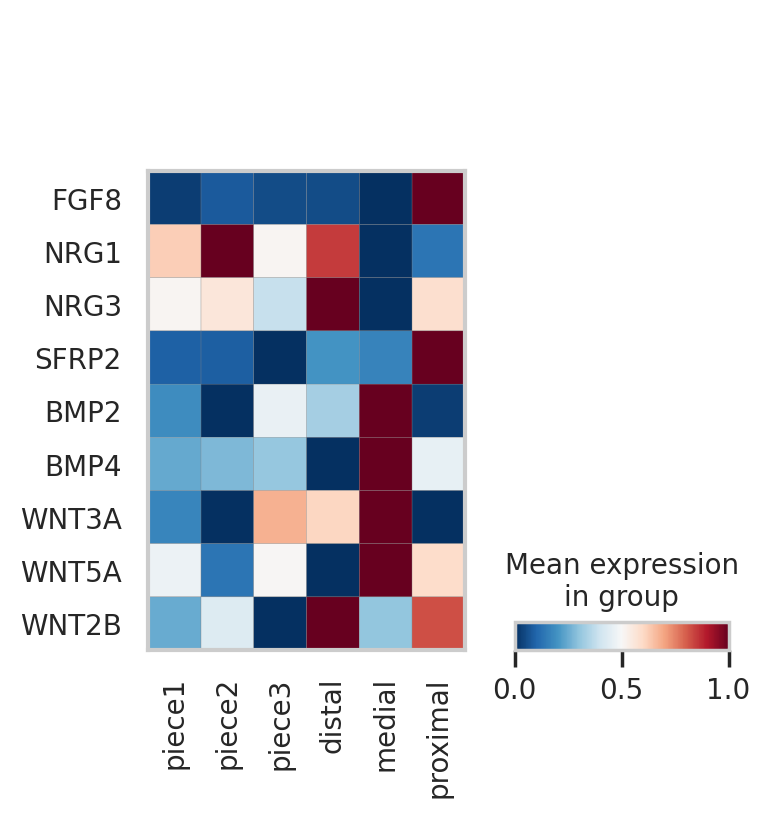

In [16]:


sns.set(rc={'figure.figsize':(6,3)})

sns.set_style("whitegrid")


sc.pl.matrixplot(adata, var_names=additionalMarkers,use_raw=True, groupby='region', dendrogram=False,
                 categories_order=["piece1","piece2","piece3","distal","medial","proximal"],
                cmap='RdBu_r', standard_scale="var",swap_axes=True)

## Distribution

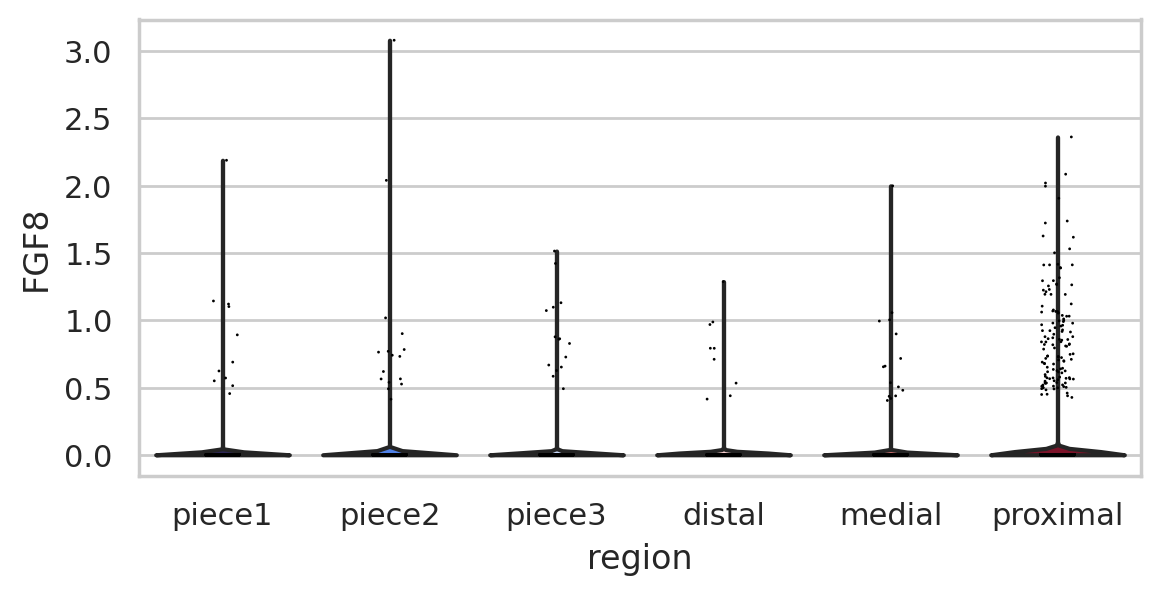

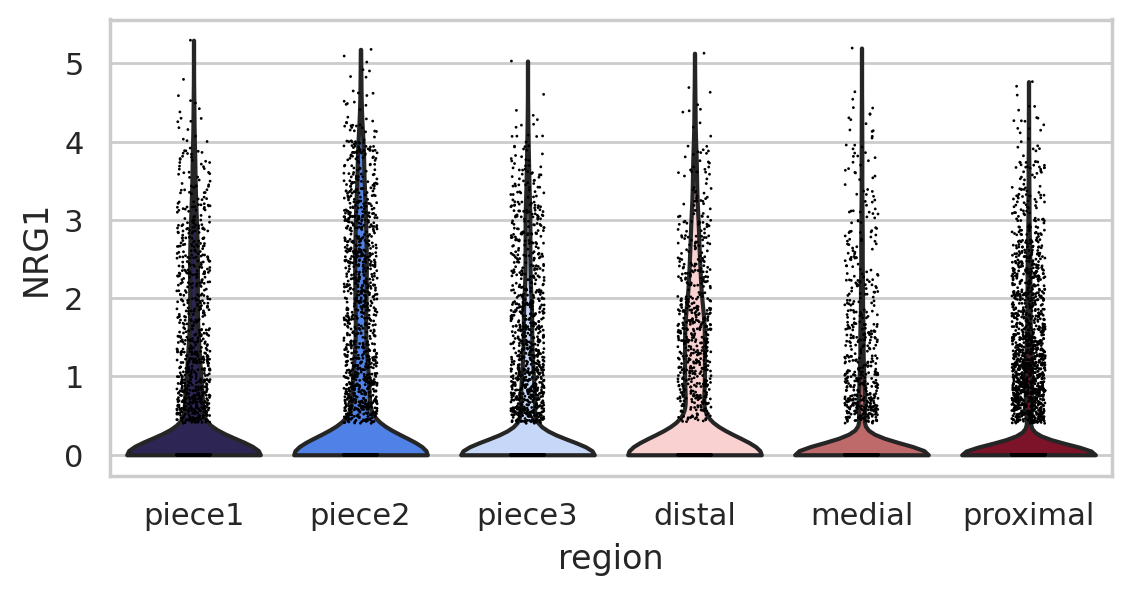

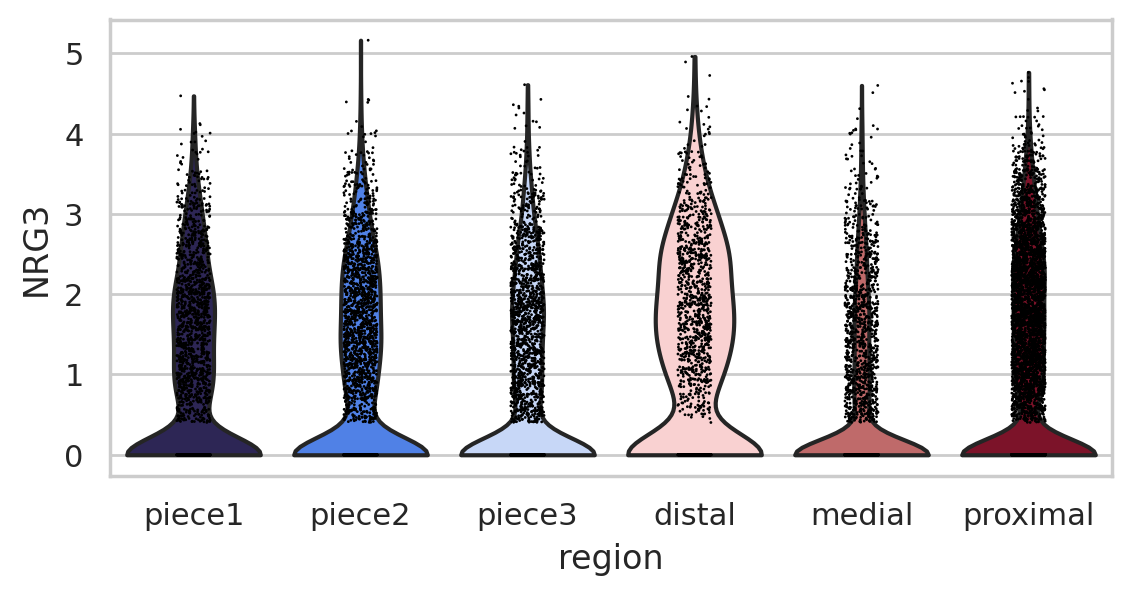

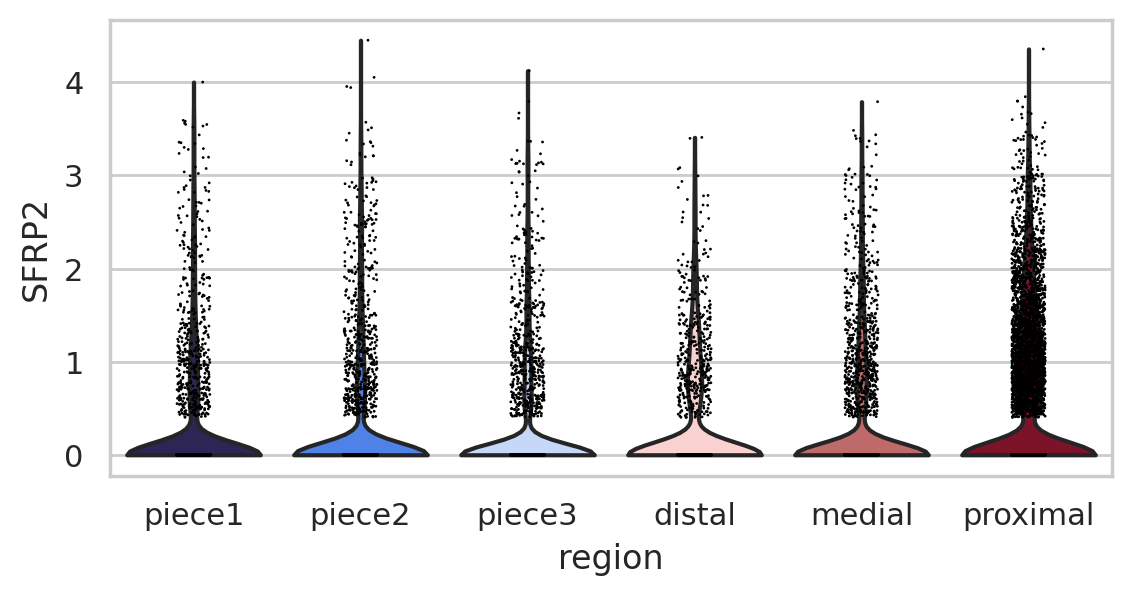

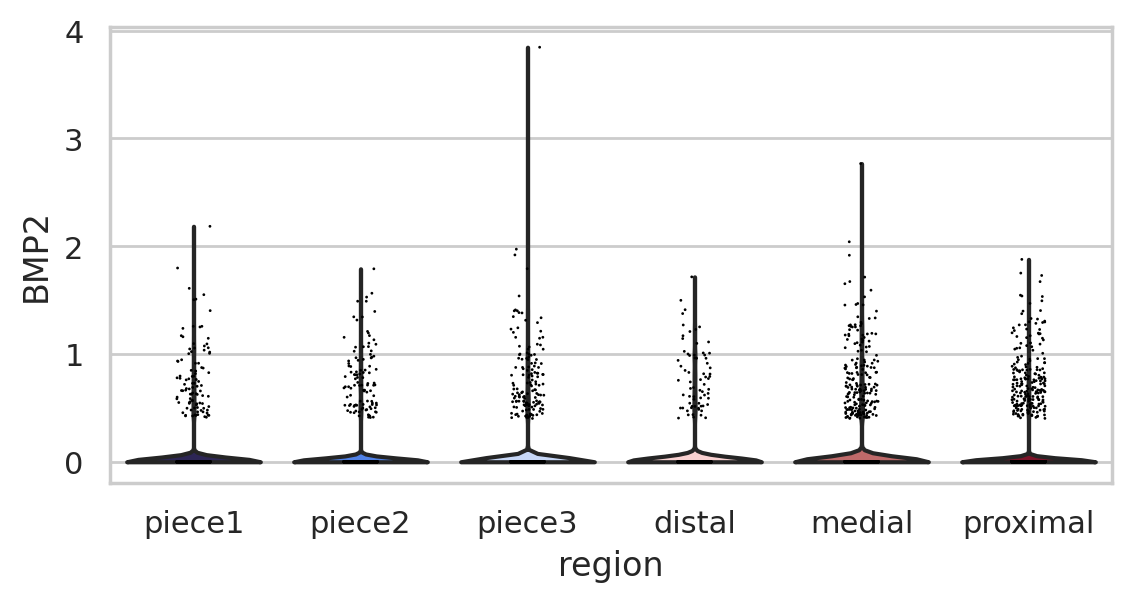

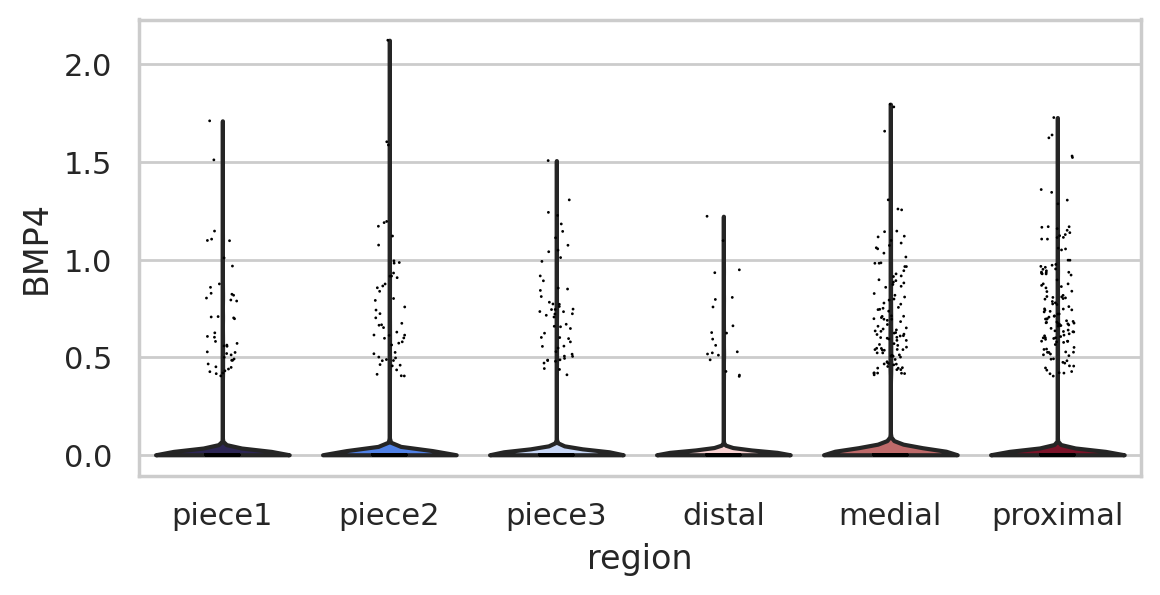

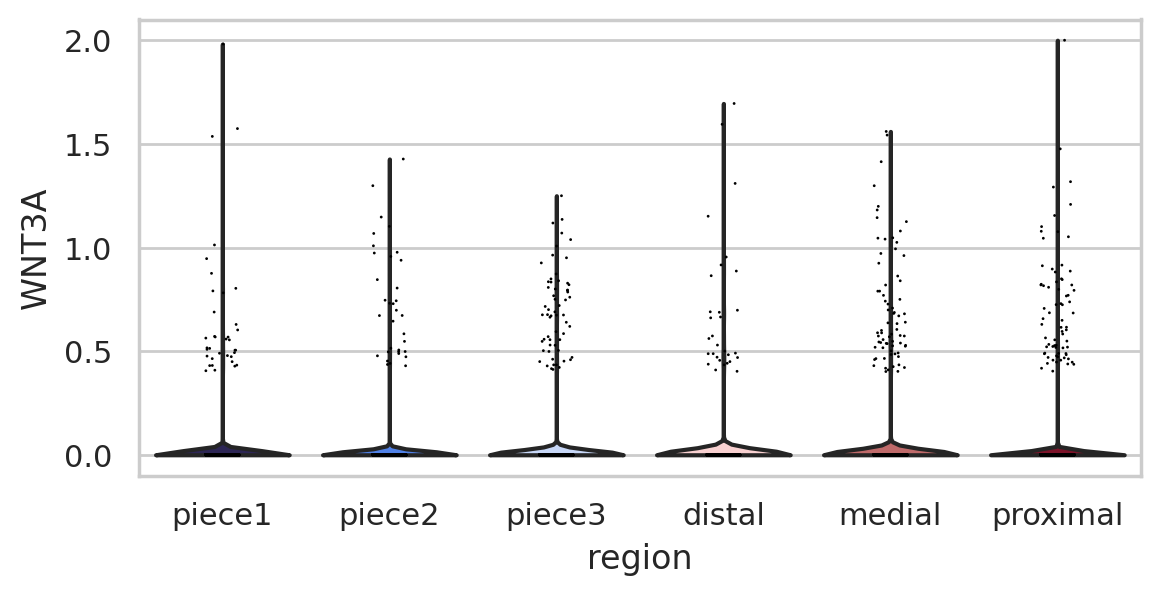

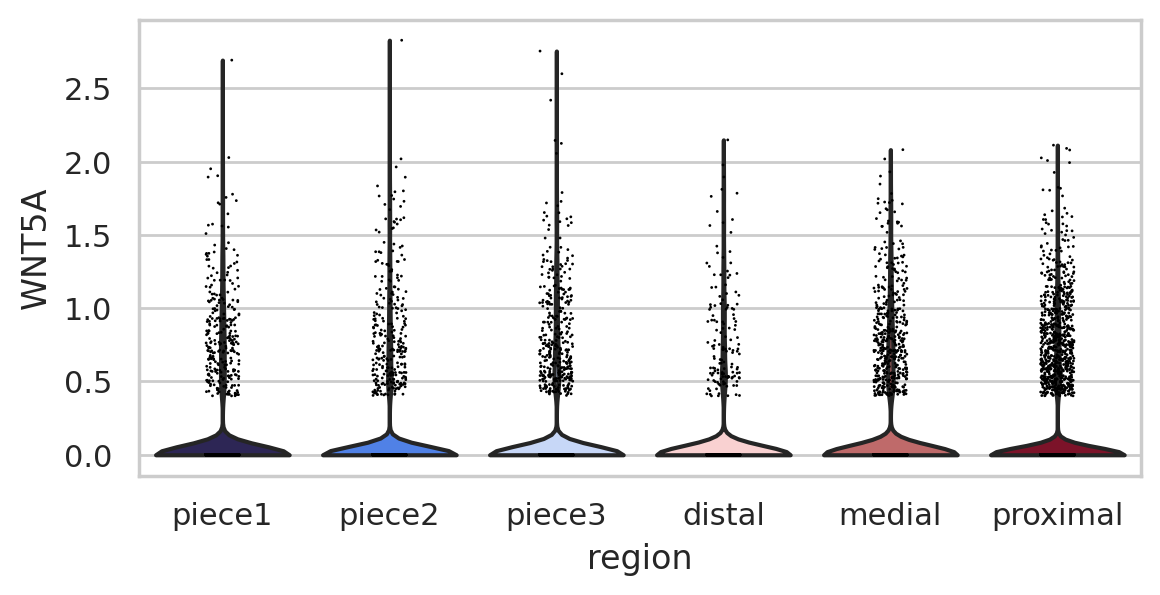

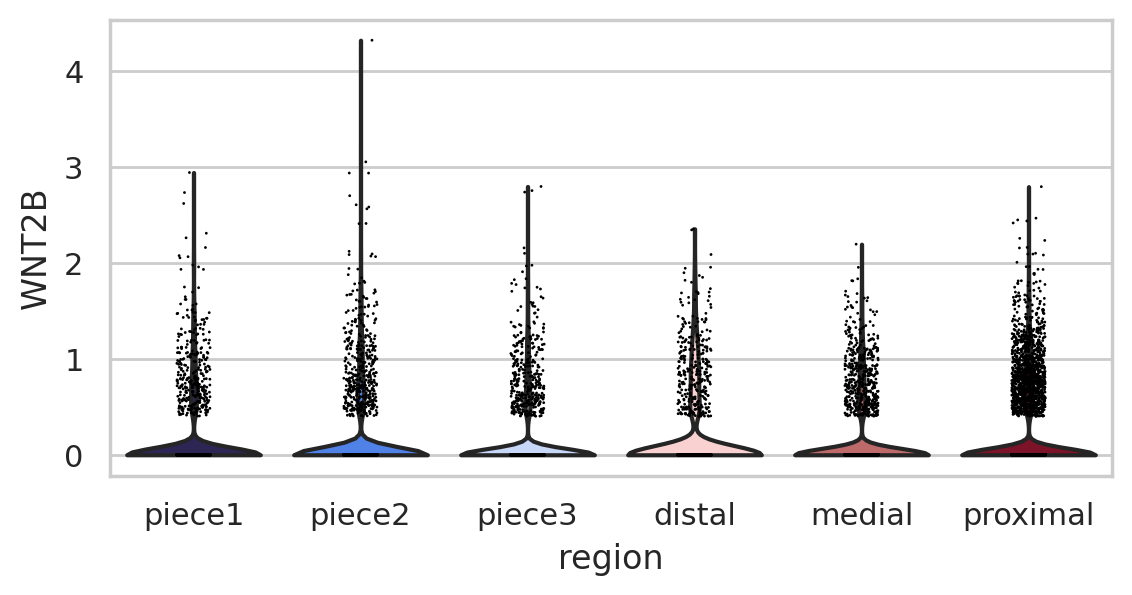

In [17]:
for gene in  [m for m in additionalMarkers if m in adata.var_names]:
    sc.pl.violin(adata, groupby="region", keys=gene, order=["piece1","piece2","piece3","distal","medial","proximal"])